In [6]:
# import를 한다

import os
from glob import glob
import pathlib
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

os.environ['GRPC_VERBOSITY']= 'NONE' # 경고 메시지를 무시하는 부분이다.
os.environ['GLOG_minloglevel']= '2'
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지를 불러온다.

# root= '/content/drive/MyDrive/DEEP LEARNING/kaggle_3m/TCGA_CS_4941_19960909' #한 폴더만 일단 학습.
# paths_mask= glob(f'{root}/*/*_mask*')
# paths_mask
# paths_imgs= [x.replace('_mask', '') for x in paths_mask] # 파일의 이름이 mask가 붙어있고 없고로 되어있으므로 이렇게 불러옴
# df= pd.DataFrame({'images': paths_imgs, 'masks':  paths_mask,})

directory = "/content/drive/MyDrive/DEEP LEARNING/kaggle_3m/data"

mask_files = glob(f"{directory}/*_mask*")
paths_imgs= [x.replace('_mask', '') for x in mask_files]

df= pd.DataFrame({'images': paths_imgs, 'masks': mask_files ,})
df

# 이미지를 전처리한다
df_trn, df_tmp= train_test_split(df,     test_size=0.2, random_state=42)
df_vld, df_tst= train_test_split(df_tmp, test_size=0.5, random_state=42) #훈련/ 시험 데이터로 분할
df_trn.isna().sum() # 결측 데이터를 확인한다

img_shape= (128, 128, 1) #이미지의 크기를 정해놓는다.
batch_size= 32

def df2gen(gen, df, col, color): #이미지의 컬러모드를 통일하는 함수 두개
    return gen.flow_from_dataframe(df, x_col=col, class_mode=None, color_mode=color, target_size=img_shape[:2], batch_size=batch_size, seed=1)

def gen_create(df, augmentation=dict()):
    gen_img= ImageDataGenerator(**augmentation)
    gen_msk= ImageDataGenerator(**augmentation)

    gen_img= df2gen(gen_img, df, 'images', 'grayscale')
    gen_msk= df2gen(gen_msk, df, 'masks',  'grayscale')

    if not gen_img or not gen_msk:
        return None

    for img, msk in zip(gen_img, gen_msk):
        if img is None or msk is None:
            continue

        if img.shape!=msk.shape:
            print(
                '\033[33mWARNING! shape mismatch!\n\033[0m'+
                'Image shape: ', img.shape,
                'Mask shape:  ', msk.shape,
            )
            #break

        img/= 255
        msk/= 255
        msk[msk>=0.5]= 1
        msk[msk< 0.5]= 0
        yield(img, msk)

gen_trn= gen_create(df_trn, dict(rotation_range=0.2,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 zoom_range=0.05,
                                 horizontal_flip=True,
                                 vertical_flip=True))
gen_vld= gen_create(df_vld)
gen_tst= gen_create(df_tst)


# 모델 구조 설정

def unet(nlevels=5):
    downconvs= [None]*nlevels

    inputs= Input(img_shape)

    #Downsampling
    for i in range(2):
        downconvs[0]= Conv2D(128, kernel_size=(3,3), padding='same')(inputs if i==0 else act)
        bn=   BatchNormalization()(downconvs[0])
        act=  Activation('relu')(bn)
    pool= MaxPooling2D((2,2))(act)

    for level in range(1, nlevels):
        for i in range(3):
            downconvs[level]= Conv2D(2**(level+7) if i<2 else 256, kernel_size=(3,3), padding='same')(pool if i==0 else act)
            bn= BatchNormalization()(downconvs[level])
            act= Activation('relu')(bn)
        pool= MaxPooling2D((2,2))(act)

    #Upsampling
    for level in range(nlevels-1, -1, -1):
        up= concatenate([Conv2DTranspose(2**(level+5), kernel_size=(2,2), strides=(2,2), padding='same')(pool if level==nlevels-1 else act), downconvs[level]], axis=3)
        conv= Conv2D(2**(level+8), kernel_size=(3,3), padding='same')(up)
        bn= BatchNormalization()(conv)
        act= Activation('relu')(bn)

    outputs= Conv2D(filters=1, kernel_size=(1,1), activation="sigmoid")(act)
    return Model(inputs=inputs, outputs=outputs)

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flat= K.flatten(y_true)
    y_pred_flat= K.flatten(y_pred)
    intersect= K.sum(y_true_flat*y_pred_flat)
    union= K.sum(y_true_flat)+K.sum(y_pred_flat)
    return (2*intersect+smooth)/(union+smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    intersect= K.sum(y_true*y_pred)
    summ= K.sum(y_true+y_pred)
    return (intersect+smooth)/(summ-intersect+smooth)

model= unet()
model.compile(Adamax(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', iou, dice_coef])
model.summary()

# 모델 학습




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          1,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 128)  │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 128)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 116,994,913 (446.30 MB)

 Trainable params: 116,961,121 (446.17 MB)

 Non-trainable params: 33,792 (132.00 KB)

In [ ]:
steps_per_epoch = len(df_trn) // batch_size + (1 if len(df_trn) % batch_size != 0 else 0)
validation_steps = len(df_vld) // batch_size + (1 if len(df_vld) % batch_size != 0 else 0)

hist= model.fit(gen_trn,
                epochs=50,
                verbose=1,
                validation_data=gen_vld,
                steps_per_epoch= len(df_trn)//batch_size,
                validation_steps=len(df_vld)//batch_size)

NameError: name 'hist' is not defined

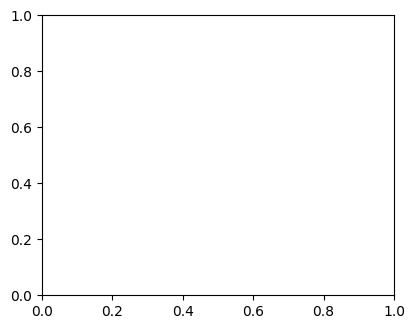

In [8]:
# 성능을 확인한다.

def plot_metric(hist, trn_metric, vld_metric, condition):
    trn= hist.history[trn_metric]
    vld= hist.history[vld_metric]
    vld_idx= condition(vld)
    vld_best= vld[vld_idx]
    epochs= list(range(1, len(trn)+1))

    plt.plot(epochs, trn, 'r', label='Training '+trn_metric.title())
    plt.plot(epochs, vld, 'g', label='Validation '+vld_metric.title())
    plt.scatter(vld_idx+1, vld_best, s=150, c='green', label='Best Epoch= %d'%(vld_idx+1))
    plt.title('Training & Validation '+trn_metric.title())
    plt.xlabel('Epochs')
    plt.ylabel(trn_metric.title())
    plt.legend()

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plot_metric(hist, 'accuracy', 'val_accuracy', np.argmax)
plt.subplot(2, 2, 2)
plot_metric(hist, 'loss', 'val_loss', np.argmin)
plt.subplot(2, 2, 3)
plot_metric(hist, 'iou', 'val_iou', np.argmax)
plt.subplot(2, 2, 4)
plot_metric(hist, 'dice_coef', 'val_dice_coef', np.argmax)
plt.tight_layout()
plt.show()

for _ in range(20):
    index= np.random.randint(1, len(df_tst.index))
    img= cv2.imread(df_tst['images'].iloc[index], 0)
    img= cv2.resize(img, (128, 128))
    img= img/255
    img= img[np.newaxis, :, :, np.newaxis]
    img_pred= model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_tst['masks'].iloc[index], 0)))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(img_pred)>0.5)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

  # 모델 저장
model.save('/content/drive/MyDrive/DEEP LEARNING/20241121_brain_tumor.keras')


In [7]:
import os
import numpy as np
import cv2
from tqdm import tqdm  # 진행 상황 표시를 위해 사용

# 저장 경로 설정
model = "/content/drive/MyDrive/DEEP LEARNING/20241121_brain_tumor.keras"
output_dir = "/content/drive/MyDrive/DEEP LEARNING/predictions"
os.makedirs(output_dir, exist_ok=True)  # 디렉토리 없으면 생성

# Prediction 저장 함수
def save_predictions(model, df_tst, output_dir, save_as_images=True, threshold=0.5):
    """
    테스트 데이터의 예측 결과를 저장합니다.

    Parameters:
    - model: 학습된 모델
    - df_tst: 테스트 데이터프레임 (이미지와 마스크 경로 포함)
    - output_dir: 예측 결과 저장 디렉토리
    - save_as_images: 이미지를 PNG로 저장할지 여부 (True: PNG, False: .npy 파일 저장)
    - threshold: 예측 마스크 임계값 (기본값: 0.5)
    """
    for idx in tqdm(range(len(df_tst)), desc="Saving Predictions"):
        # 이미지 불러오기
        img_path = df_tst['images'].iloc[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지 로드
        img = cv2.resize(img, (128, 128))  # 모델 입력 크기에 맞게 조정
        img = img / 255.0  # 정규화
        img = img[np.newaxis, :, :, np.newaxis]  # (1, H, W, C) 형태로 변환

        # 모델 예측
        pred = model.predict(img)[0, :, :, 0]  # (H, W) 형태로 변환

        # Threshold 적용
        pred_binary = (pred > threshold).astype(np.uint8)  # 0 또는 1로 이진화

        # 파일 저장
        basename = os.path.basename(img_path).split('.')[0]  # 확장자 제거한 파일 이름
        if save_as_images:
            save_path = os.path.join(output_dir, f"{basename}_pred.png")
            cv2.imwrite(save_path, pred_binary * 255)  # 0~255 범위로 저장
        else:
            save_path = os.path.join(output_dir, f"{basename}_pred.npy")
            np.save(save_path, pred_binary)

    print(f"Predictions saved to: {output_dir}")

# 호출 예시
save_predictions(
    model=model,  # 학습된 모델
    df_tst=df_tst,  # 테스트 데이터프레임
    output_dir=output_dir,  # 결과 저장 경로
    save_as_images=True,  # True: PNG 이미지 저장, False: .npy 파일 저장
    threshold=0.5  # 마스크 임계값
)



Saving Predictions:   0%|          | 0/384 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'predict'

In [9]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

# 예측 결과 저장 디렉토리 설정
prediction_dir = "/content/drive/MyDrive/DEEP LEARNING/predictions"

# 픽셀 수를 계산하는 함수
def count_white_pixels(prediction_dir):
    """
    예측 결과 이미지에서 흰색 픽셀(종양 부분)을 계산합니다.

    Parameters:
    - prediction_dir: 예측 결과가 저장된 디렉토리 경로

    Returns:
    - result: 파일 이름과 흰색 픽셀 수를 담은 리스트
    """
    result = []
    prediction_files = glob(os.path.join(prediction_dir, "*.png"))  # PNG 파일 목록 가져오기

    for file_path in tqdm(prediction_files, desc="Counting white pixels"):
        # 이미지 불러오기
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지 로드

        # 흰색 픽셀(값이 255인 픽셀) 개수 계산
        white_pixel_count = np.sum(img == 255)

        # 결과 저장
        file_name = os.path.basename(file_path)
        result.append({"file_name": file_name, "white_pixel_count": white_pixel_count})

    return result

# 호출 예시
white_pixel_results = count_white_pixels(prediction_dir)

# 결과를 데이터프레임으로 변환
import pandas as pd
df_white_pixels = pd.DataFrame(white_pixel_results)

# 데이터프레임 출력
print(df_white_pixels)

# CSV로 저장 (옵션)
output_csv = "white_pixel_counts.csv"
df_white_pixels.to_csv(output_csv, index=False)
print(f"Pixel counts saved to: {output_csv}")



Counting white pixels: 100%|██████████| 384/384 [00:03<00:00, 116.74it/s]

                             file_name  white_pixel_count
0    TCGA_CS_6668_20011025_11_pred.png                  0
1    TCGA_HT_A61B_19991127_20_pred.png                  0
2    TCGA_DU_6407_19860514_23_pred.png                616
3     TCGA_HT_7473_19970826_6_pred.png                  0
4     TCGA_HT_8111_19980330_4_pred.png                  0
..                                 ...                ...
379  TCGA_DU_8163_19961119_31_pred.png                  0
380  TCGA_DU_5872_19950223_61_pred.png                  0
381   TCGA_DU_5852_19950709_5_pred.png                  0
382   TCGA_FG_7643_20021104_9_pred.png                  0
383  TCGA_DU_6407_19860514_35_pred.png                 42

[384 rows x 2 columns]
Pixel counts saved to: white_pixel_counts.csv


In [9]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

# 예측 이미지 디렉토리
prediction_dir = "/content/drive/MyDrive/DEEP LEARNING/predictions"

# 화이트 픽셀이 포함된 이미지만 필터링
def filter_white_pixel_images(prediction_dir):
    """
    화이트 픽셀이 포함된 이미지를 필터링합니다.

    Parameters:
    - prediction_dir: 예측 이미지가 저장된 디렉토리 경로

    Returns:
    - result: 화이트 픽셀이 있는 이미지의 파일 경로와 픽셀 수를 담은 리스트
    """
    prediction_files = glob(os.path.join(prediction_dir, "*.png"))  # PNG 파일 목록 가져오기
    result = []

    for file_path in tqdm(prediction_files, desc="Filtering images with white pixels"):
        # 이미지 읽기
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 흑백으로 로드

        # 화이트 픽셀 개수 계산
        white_pixel_count = np.sum(img == 255)

        # 화이트 픽셀이 있는 경우만 결과에 추가
        if white_pixel_count > 0:
            result.append({"file_name": file_path, "white_pixel_count": white_pixel_count})

    return result

# 호출 및 결과 확인
filtered_results = filter_white_pixel_images(prediction_dir)

# 화이트 픽셀이 있는 이미지 출력
if filtered_results:
    print(f"Found {len(filtered_results)} images with white pixels.")
    for item in filtered_results[:5]:  # 일부만 출력
        print(f"File: {item['file_name']}, White Pixel Count: {item['white_pixel_count']}")
else:
    print("No images with white pixels found.")


Filtering images with white pixels: 100%|██████████| 384/384 [00:01<00:00, 201.61it/s]

Found 118 images with white pixels.
File: /content/drive/MyDrive/DEEP LEARNING/predictions/TCGA_DU_6407_19860514_23_pred.png, White Pixel Count: 616
File: /content/drive/MyDrive/DEEP LEARNING/predictions/TCGA_DU_6408_19860521_38_pred.png, White Pixel Count: 984
File: /content/drive/MyDrive/DEEP LEARNING/predictions/TCGA_DU_5855_19951217_19_pred.png, White Pixel Count: 933
File: /content/drive/MyDrive/DEEP LEARNING/predictions/TCGA_FG_7637_20000922_19_pred.png, White Pixel Count: 519
File: /content/drive/MyDrive/DEEP LEARNING/predictions/TCGA_DU_6408_19860521_23_pred.png, White Pixel Count: 178


In [10]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd

# 예측 이미지 디렉토리 설정
prediction_dir = "predictions"  # 예측 이미지가 저장된 디렉토리

def calculate_white_pixel_ratio_for_filtered_images(prediction_dir):
    """
    화이트 픽셀이 포함된 이미지에서 흰색 픽셀 비율을 계산하여 종양 크기를 평가합니다.

    Parameters:
    - prediction_dir: 예측 이미지가 저장된 디렉토리 경로

    Returns:
    - result: 화이트 픽셀 비율과 관련된 정보를 포함한 리스트
    """
    prediction_files = glob(os.path.join(prediction_dir, "*.png"))  # PNG 파일 가져오기
    result = []

    for file_path in tqdm(prediction_files, desc="Processing images with white pixels"):
        # 이미지 불러오기
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지 로드
        total_pixels = img.shape[0] * img.shape[1]  # 전체 픽셀 수
        white_pixel_count = np.sum(img == 255)  # 화이트 픽셀 수

        # 화이트 픽셀 비율 계산
        if white_pixel_count > 0:  # 화이트 픽셀이 있는 이미지만 처리
            white_pixel_ratio = white_pixel_count / total_pixels
            result.append({
                "file_name": os.path.basename(file_path),
                "white_pixel_count": white_pixel_count,
                "total_pixels": total_pixels,
                "white_pixel_ratio": white_pixel_ratio
            })

    return result

# 호출 및 결과 저장
filtered_results = calculate_white_pixel_ratio_for_filtered_images(prediction_dir)

# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(filtered_results)

# 화이트 픽셀 비율로 종양 크기를 평가: 분포 확인
print(df_results)

# CSV 저장 (옵션)
output_csv = "filtered_white_pixel_ratios.csv"
df_results.to_csv(output_csv, index=False)
print(f"Filtered white pixel ratios saved to: {output_csv}")



Processing images with white pixels: 0it [00:00, ?it/s]

Empty DataFrame
Columns: []
Index: []
Filtered white pixel ratios saved to: filtered_white_pixel_ratios.csv


In [13]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd

# 예측 이미지 디렉토리
prediction_dir = "/content/drive/MyDrive/DEEP LEARNING/predictions"

# 화이트 픽셀 필터링 및 거리 계산 함수
def calculate_center_distances_for_white_pixel_images(prediction_dir):
    """
    화이트 픽셀이 포함된 이미지에서 종양 중심과 이미지 중심 간의 거리를 계산합니다.

    Parameters:
    - prediction_dir: 예측 이미지가 저장된 디렉토리 경로

    Returns:
    - result: 화이트 픽셀 정보와 중심 거리 정보를 포함한 리스트
    """
    prediction_files = glob(os.path.join(prediction_dir, "*.png"))  # PNG 파일 가져오기
    result = []

    for file_path in tqdm(prediction_files, desc="Processing images with white pixels"):
        # 이미지 불러오기
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지 로드
        height, width = img.shape
        img_center = (width / 2, height / 2)  # 이미지 중심 (x, y)

        # 흰색 픽셀 좌표 가져오기
        white_pixels = np.argwhere(img == 255)  # 화이트 픽셀의 (y, x) 좌표
        if len(white_pixels) > 0:  # 화이트 픽셀이 있는 경우만 처리
            tumor_center = white_pixels.mean(axis=0)  # 흰색 픽셀의 평균 좌표 (y, x)
            tumor_center = (tumor_center[1], tumor_center[0])  # (x, y)로 변환

            # 유클리드 거리 계산
            distance = np.sqrt((tumor_center[0] - img_center[0]) ** 2 +
                               (tumor_center[1] - img_center[1]) ** 2)

            # 결과 저장
            result.append({
                "file_name": os.path.basename(file_path),
                "tumor_center_x": tumor_center[0],
                "tumor_center_y": tumor_center[1],
                "image_center_x": img_center[0],
                "image_center_y": img_center[1],
                "white_pixel_count": len(white_pixels),
                "distance": distance
            })

    return result

# 호출 및 결과 저장
center_distances = calculate_center_distances_for_white_pixel_images(prediction_dir)

# 결과를 데이터프레임으로 변환
df_center_distances = pd.DataFrame(center_distances)

# 거리 결과 출력
print(df_center_distances)

# CSV 저장 (옵션)
output_csv = "white_pixel_center_distances.csv"
df_center_distances.to_csv(output_csv, index=False)
print(f"Tumor center distances saved to: {output_csv}")


Processing images with white pixels: 100%|██████████| 384/384 [00:01<00:00, 192.43it/s]

                             file_name  tumor_center_x  tumor_center_y  \
0    TCGA_DU_6407_19860514_23_pred.png       50.644481       65.730519   
1    TCGA_DU_6408_19860521_38_pred.png       54.272358       56.252033   
2    TCGA_DU_5855_19951217_19_pred.png       54.092176       48.109325   
3    TCGA_FG_7637_20000922_19_pred.png       41.479769       61.672447   
4    TCGA_DU_6408_19860521_23_pred.png       46.573034       54.983146   
..                                 ...             ...             ...   
113  TCGA_HT_7877_19980917_12_pred.png       75.625000       55.750000   
114  TCGA_DU_7013_19860523_27_pred.png       88.148387       56.187097   
115  TCGA_DU_8164_19970111_29_pred.png       55.365854       67.756098   
116  TCGA_FG_A4MT_20020212_24_pred.png       88.532995       66.756345   
117  TCGA_DU_6407_19860514_35_pred.png       65.190476       48.261905   

     image_center_x  image_center_y  white_pixel_count   distance  
0              64.0            64.0        

In [15]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm

# 윤곽선에서 꼭짓점 개수 계산
def calculate_vertex_count(mask_image):
    """
    마스크 이미지에서 화이트 픽셀 기반 윤곽선의 꼭짓점 개수를 계산합니다.

    Parameters:
    - mask_image: 2D numpy array (binary mask)

    Returns:
    - int: 꼭짓점 개수
    """
    # 윤곽선 찾기
    contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0  # 윤곽선이 없으면 꼭짓점도 없음

    largest_contour = max(contours, key=cv2.contourArea)

    # 윤곽선 단순화 (epsilon은 단순화 정도를 조정)
    epsilon = 0.02 * cv2.arcLength(largest_contour, closed=True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, closed=True)

    # 꼭짓점 개수 반환
    return len(approx)

# 예측 디렉토리 처리
def process_prediction_images_with_vertices(prediction_dir):
    """
    예측 디렉토리 내의 모든 이미지를 처리하여 꼭짓점 개수를 계산합니다.

    Parameters:
    - prediction_dir: str, 예측 이미지 디렉토리 경로

    Returns:
    - pd.DataFrame: 파일 이름 및 꼭짓점 개수
    """
    prediction_files = glob(prediction_dir + "/*.png")
    data = []

    for file_path in tqdm(prediction_files, desc="Processing images"):
        # 마스크 이미지 읽기
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # 화이트 픽셀 확인
        if np.sum(mask == 255) == 0:
            continue  # 화이트 픽셀이 없는 이미지는 건너뜀

        # 꼭짓점 개수 계산
        vertex_count = calculate_vertex_count(mask)

        # 결과 저장
        data.append({"file_name": file_path, "vertex_count": vertex_count})

    return pd.DataFrame(data)

# 예측 이미지 디렉토리
prediction_dir = "/content/drive/MyDrive/DEEP LEARNING/predictions"

# 결과 처리
df_vertices = process_prediction_images_with_vertices(prediction_dir)

# 결과 출력
print(df_vertices)

# CSV 저장
output_csv = "vertex_counts.csv"
df_vertices.to_csv(output_csv, index=False)
print(f"Vertex counts saved to: {output_csv}")


Processing images: 100%|██████████| 384/384 [00:02<00:00, 191.94it/s]

                                             file_name  vertex_count
0    /content/drive/MyDrive/DEEP LEARNING/predictio...             8
1    /content/drive/MyDrive/DEEP LEARNING/predictio...            12
2    /content/drive/MyDrive/DEEP LEARNING/predictio...            10
3    /content/drive/MyDrive/DEEP LEARNING/predictio...             9
4    /content/drive/MyDrive/DEEP LEARNING/predictio...             9
..                                                 ...           ...
113  /content/drive/MyDrive/DEEP LEARNING/predictio...             6
114  /content/drive/MyDrive/DEEP LEARNING/predictio...             9
115  /content/drive/MyDrive/DEEP LEARNING/predictio...             8
116  /content/drive/MyDrive/DEEP LEARNING/predictio...            11
117  /content/drive/MyDrive/DEEP LEARNING/predictio...             8

[118 rows x 2 columns]
Vertex counts saved to: vertex_counts.csv
